<div style='background-color: #fff3cd; border: 1px solid #ffeaa7; border-radius: 4px; padding: 15px; margin: 10px 0; border-left: 4px solid #f39c12;'>
<h3 style='color: #856404; margin-top: 0;'>⚠️ EXECUTION WARNING</h3>
<p style='color: #856404; margin-bottom: 0;'><strong>This notebook may not execute properly in the current environment.</strong></p>
<p style='color: #856404; margin-bottom: 0;'>Some cells may have failed during automated testing. Please review the notebook content and test manually before use.</p>
<p style='color: #856404; margin-bottom: 0; font-size: 0.9em;'><em>Generated during CI/CD pipeline - some outputs may be incomplete or missing.</em></p>
</div>


![STScI Logo](../../../_static/stsci_header.png)

<a id=top></a>
# 1D Spectra Extraction <a class="tocSkip">

## Table of Contents
- [0. Introduction](#section0)
    - [0.1 Import Necessary Packages](#section0.1)
    - [0.2 Collect Data Set From the MAST Archive Using Astroquery](#section0.2)
- [1. <code>x1d</code> FITS File Structure](#section1)
- [2. Plot the Extraction Region](#section2)
- [3. Extracted Spectra of STIS Echelle](#section3)
- [About this Notebook](#about)

<a id=section0></a>

## 0. Introduction

The `x1d` FITS file is the one-dimensional extracted spectra for individual imsets of `flt`, `sfl`, or `crj` images. The `x1d` file is in binary table with the science information stored in the 'SCI' extension. In this notebook, we will show how to visualize the extraction regions when generating the `x1d` extracted spectra from a `flt` image. In some cases when users work with images with multiple sources or extended background, they might want to customize extraction. The goal of visualizing extraction region is to help confirm that the proper extraction parameters are selected, and the extraction regions do not overlap. 

For more information on extracted spectra, see the STIS Data Handbook: [5.5 Working with Extracted Spectra](https://hst-docs.stsci.edu/stisdhb/chapter-5-stis-data-analysis/5-5-working-with-extracted-spectra)

<a id=section0.1></a>

### 0.1 Import Necessary Packages
- `astropy.io.fits` and `astropy.table.Table` for accessing FITS files
- `astroquery.mast.Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `os` for managing system paths
- `numpy` to handle array functions
- `stistools` for operations on STIS Data
- `matplotlib` for plotting data

In [1]:
# Import for: Reading in fits file
from astropy.io import fits
from astropy.table import Table

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
import os

# Import for: Quick Calculation and Data Analysis
import numpy as np

# Import for: Operations on STIS Data
# import stistools

# Import for: Plotting and specifying plotting parameters
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
# from matplotlib.ticker import FixedLocator

In [2]:
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.cmap'] = 'viridis'
matplotlib.rcParams['image.interpolation'] = 'none'

<a id=section0.2></a>

### 0.2 Collect Data Set From the MAST Archive Using Astroquery
There are other ways to download data from MAST such as using CyberDuck. The steps of collecting data is beyond the scope of this notebook, and we are only showing how to use astroquery.

In [3]:
# change this field in you have a specific dataset to be explored
obs_id = 'odj102010'
# Search target object by obs_id
target = Observations.query_criteria(obs_id=obs_id)
# get a list of files assiciated with that target
target_list = Observations.get_product_list(target)
# Download fits files
result = Observations.download_products(target_list, extension=['_flt.fits', '_x1d.fits'], productType=['SCIENCE'])
flt_filename = os.path.join(f'./mastDownload/HST/{obs_id}/{obs_id}_flt.fits')
x1d_filename = os.path.join(f'./mastDownload/HST/{obs_id}/{obs_id}_x1d.fits')

INFO: Found cached file ./mastDownload/HST/odj102010/odj102010_flt.fits with expected size 10535040. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/odj102010/odj102010_x1d.fits with expected size 77760. [astroquery.query]


<a id=section1></a>

## 1. `x1d` FITS File Structure
The `x1d` file is a multi-extension FITS file with header information stored in the primary extension (note that for CCD data the similar extension is `sx1`), and the science data stored in the first extension called "SCI".

In [4]:
fits.info(x1d_filename)

Filename: ./mastDownload/HST/odj102010/odj102010_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     275   ()      
  1  SCI           1 BinTableHDU    157   1R x 19C   [1I, 1I, 1024D, 1024E, 1024E, 1024E, 1024E, 1024E, 1024E, 1024I, 1E, 1E, 1I, 1E, 1E, 1E, 1E, 1024E, 1E]   


The SCI extension contains the science data of the spectra along the spectral direction such as the wavelength and the flux, and information on the extraction region and the background region when performing the 1D spectra extraction:

| Column name   | Description | Data Type |
| :---------- | :---------- | :---------- |
| EXTRLOCY      | an array that gives the location of the center of the spectral trace for each pixel along the Y direction | float32 array[1024] |
| A2CENTER      | row number in the y direction at which the spectral trace is centered | float32 |
| EXTRSIZE      | height of extraction region | float32 |
| BK1SIZE     | height of background region above the extraction region | float32 |
| BK2SIZE     | height of background region below the extraction region | float32 |
| BK1OFFST    | background region offset from the center of the extraction region above the extraction region | float32 |
| BK2OFFST    | background region offset from the center of the extraction region below the extraction region | float32 |

In [5]:
cols = ['SPORDER', 'WAVELENGTH', 'FLUX', 'EXTRLOCY', 'A2CENTER', 'EXTRSIZE', 'BK1SIZE', 'BK2SIZE', 'BK1OFFST', 'BK2OFFST']
Table.read(x1d_filename)[cols]

SPORDER,WAVELENGTH,FLUX,EXTRLOCY,A2CENTER,EXTRSIZE,BK1SIZE,BK2SIZE,BK1OFFST,BK2OFFST
,Angstroms,erg / (Angstrom s cm2),pix,pix,pix,pix,pix,pix,pix
int16,float64[1024],float32[1024],float32[1024],float32,float32,float32,float32,float32,float32
1,1513.611692349868 .. 1567.668670092399,1.969044e-12 .. 9.896183e-14,382.2857 .. 397.2364,389.5777,11,5,5,-300,300


**Note that X1D columns in pixel units (e.g. `EXTRLOCY`) are in one-indexed coordinates. Thus when visualizing the extraction region with Python (zero-indexed), the pixel coordinates need to be subtracted by 1. Additionally, the n-th pixel (in one-index coordinates) ranges from n-0.5 to n+0.5.**

<a id=section2></a>

## 2. Plot the Extraction Region

**Left:**  The 2D `FLT` image.

**Right:**  The 2D `FLT` image with extraction regions over-plotted. The extraction region is plotted in red, and the 2 background regions are plotted in orange.

To zoom in to a specific region along the Y axis, pass in the optional parameter yrange.

In [6]:
def show_extraction_regions(x1d_filename, flt_filename, sci_ext=1, row=0, xrange=None, yrange=None):
    
    fig, axes = plt.subplots(1, 2, sharey=True)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.88)
    fig.set_figwidth(10)
    fig.set_figheight(5)
    fig.suptitle(os.path.basename(x1d_filename))
    
    x1d = fits.getdata(x1d_filename, ext=sci_ext)[row]
    flt = fits.getdata(flt_filename, ext=('SCI', sci_ext))
    
    # LEFT & Right PLOTS:
    for ax in axes[0:2]:
        # Display the 2D FLT spectrum on the left:
        ax.imshow(flt, origin='lower', interpolation='none', aspect='auto', vmin=-6, vmax=15)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    # Right PLOT:
    axes[1].set_title(f"A2CENTER={x1d['A2CENTER']:.2f}")
    # Extraction region in red:
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1, 'r:', alpha=0.6)
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1 - x1d['EXTRSIZE']//2,
                 color='red', alpha=0.6)
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1 + x1d['EXTRSIZE']//2,
                 color='red', alpha=0.6)
    # Background regions in orange:
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1 + x1d['BK1OFFST'] - x1d['BK1SIZE']//2,
                 color='orange', alpha=0.6)
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1 + x1d['BK1OFFST'] + x1d['BK1SIZE']//2,
                 color='orange', alpha=0.6)
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1 + x1d['BK2OFFST'] - x1d['BK2SIZE']//2, 
                 color='orange', alpha=0.6)
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1 + x1d['BK2OFFST'] + x1d['BK2SIZE']//2, 
                 color='orange', alpha=0.6)
    
    axes[0].set_xlim(-0.5, 1023.5)
    axes[0].set_ylim(-0.5, 1023.5)
    axes[1].set_xlim(-0.5, 1023.5)
    axes[1].set_ylim(-0.5, 1023.5)
    
    if xrange is not None:
        axes[0].set_xlim(xrange[0], xrange[1])
        axes[1].set_xlim(xrange[0], xrange[1])
    if yrange is not None:
        axes[0].set_ylim(yrange[0], yrange[1])
        axes[1].set_ylim(yrange[0], yrange[1])

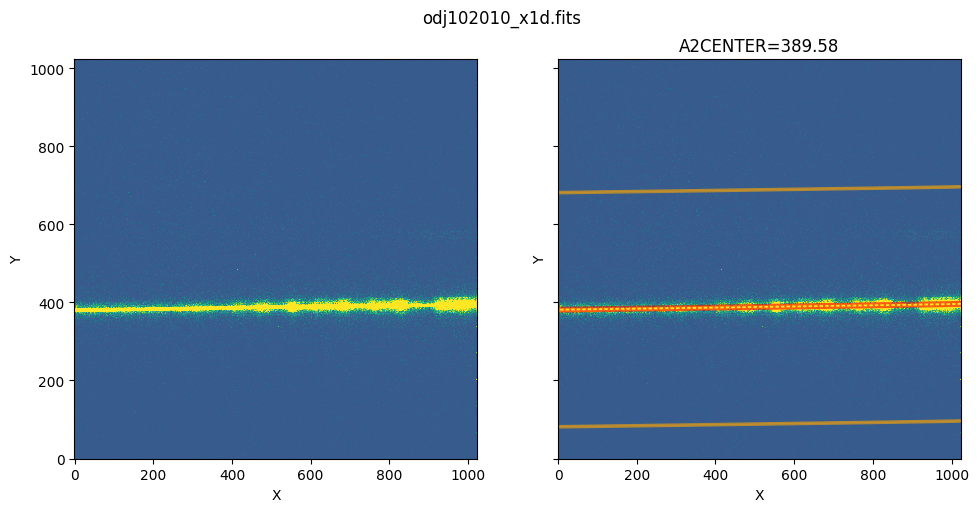

In [7]:
show_extraction_regions(x1d_filename, flt_filename)

Zoom in to the extraction region:

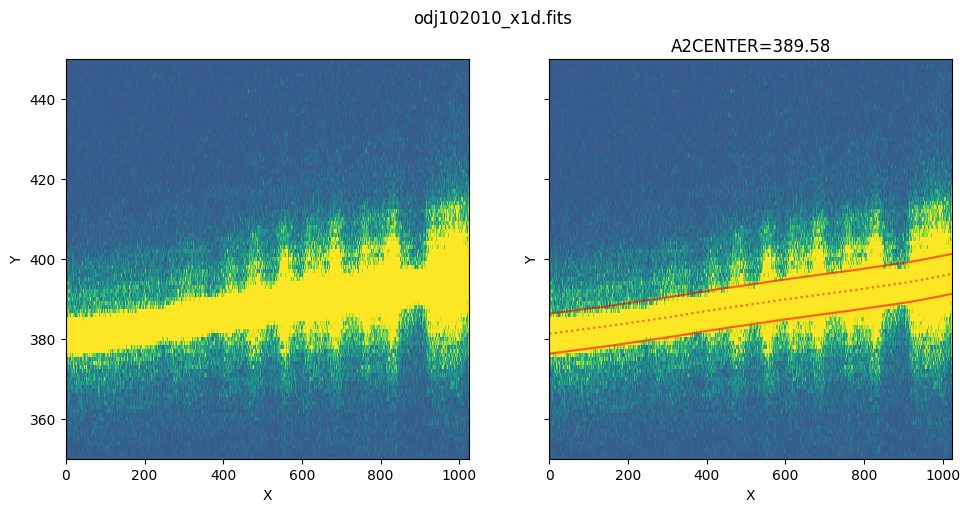

In [8]:
show_extraction_regions(x1d_filename, flt_filename, yrange=[350, 450])

Zoom in to the background region above the extraction region:

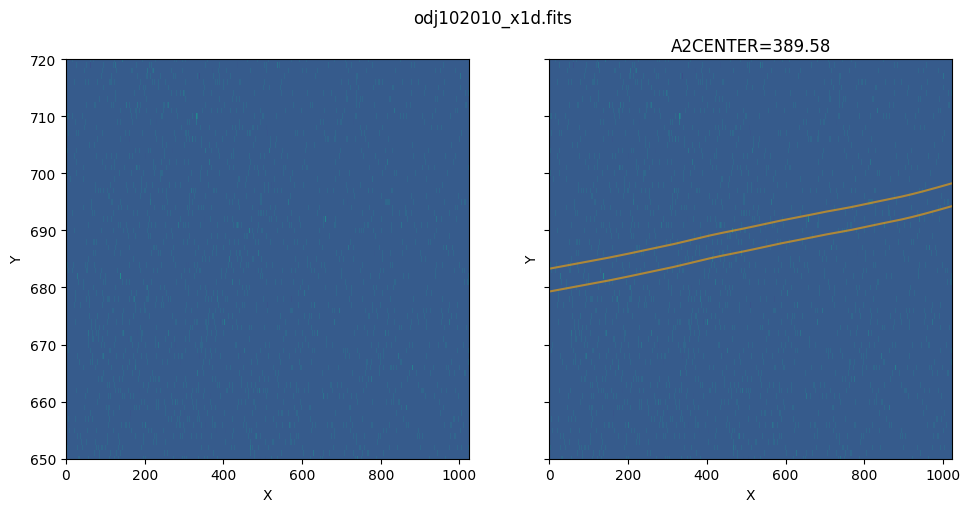

In [9]:
show_extraction_regions(x1d_filename, flt_filename, yrange=[650, 720])

<a id=section3></a>

## 3. Extracted Spectra of STIS Echelle
The method of visualizing the extracted region also applies to echelle data, except that echelle data has multiple spectra orders, and therefore has multiple `EXTRLOCY` corresponding to each `SPORDER`. In the plotting method, there is a parameter called 'row' which specifies the `SPORDER` we want to extract. We'll show how to visualize the extracted region for STIS echelle data.

In [10]:
# Download the octx01030 dataset, which is a NUV-MAMA echelle data
obs_id = 'octx01030'
# Search target objscy by obs_id
target = Observations.query_criteria(obs_id=obs_id)
# get a list of files assiciated with that target
echelle_list = Observations.get_product_list(target)
# Download fits files
result = Observations.download_products(echelle_list, extension=['_flt.fits', '_x1d.fits'], productType=['SCIENCE',])
echelle_flt = os.path.join(f'./mastDownload/HST/{obs_id}/{obs_id}_flt.fits')
echelle_x1d = os.path.join(f'./mastDownload/HST/{obs_id}/{obs_id}_x1d.fits')

INFO: Found cached file ./mastDownload/HST/octx01030/octx01030_flt.fits with expected size 84139200. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/octx01030/octx01030_x1d.fits with expected size 7629120. [astroquery.query]


As shown in the table data, there are multiple rows with each row having a different `SPORDER`. Each row also has different `EXTRLOCY`, which corresponds to different extraction regions in the `flt` image for each `SPORDER`.

In [11]:
cols = ['SPORDER', 'WAVELENGTH', 'FLUX', 'EXTRLOCY', 'EXTRSIZE', 'BK1SIZE', 'BK2SIZE', 'BK1OFFST', 'BK2OFFST']
Table.read(echelle_x1d, hdu=1)[cols]

SPORDER,WAVELENGTH,FLUX,EXTRLOCY,EXTRSIZE,BK1SIZE,BK2SIZE,BK1OFFST,BK2OFFST
,Angstroms,erg / (Angstrom s cm2),pix,pix,pix,pix,pix,pix
int16,float64[1024],float32[1024],float32[1024],float32,float32,float32,float32,float32
66,3067.682086787238 .. 3119.012536824325,-2.024925e-14 .. 2.961075e-12,19.4528 .. 9.476286,7,5,5,28.01995,-28.77343
67,3021.857426990342 .. 3072.451048939282,-1.016979e-14 .. 3.081053e-12,75.9551 .. 66.73717,7,5,5,27.28738,-28.01995
68,2977.380919743117 .. 3027.257338436938,-3.668029e-14 .. 1.092327e-12,131.2862 .. 122.4106,7,5,5,26.57536,-27.28738
69,2934.193937177996 .. 2983.372006753561,-2.182534e-14 .. 2.149785e-12,184.4561 .. 176.3899,7,5,5,25.88353,-26.57536
70,2892.241202224274 .. 2940.739045949361,-1.473246e-14 .. 3.039156e-12,236.3518 .. 228.9839,7,5,5,25.21152,-25.88353
71,2851.470552596696 .. 2899.305600156981,-3.943758e-15 .. 2.763269e-12,286.8198 .. 280.1042,7,5,5,24.55895,-25.21152
72,2811.832724454624 .. 2859.021746892561,-7.33356e-15 .. 7.601616e-13,335.8839 .. 329.9276,7,5,5,23.92547,-24.55895
73,2773.281153845325 .. 2819.840296326157,-1.82008e-14 .. 1.55503e-12,383.655 .. 378.4149,7,5,5,23.31071,-23.92547


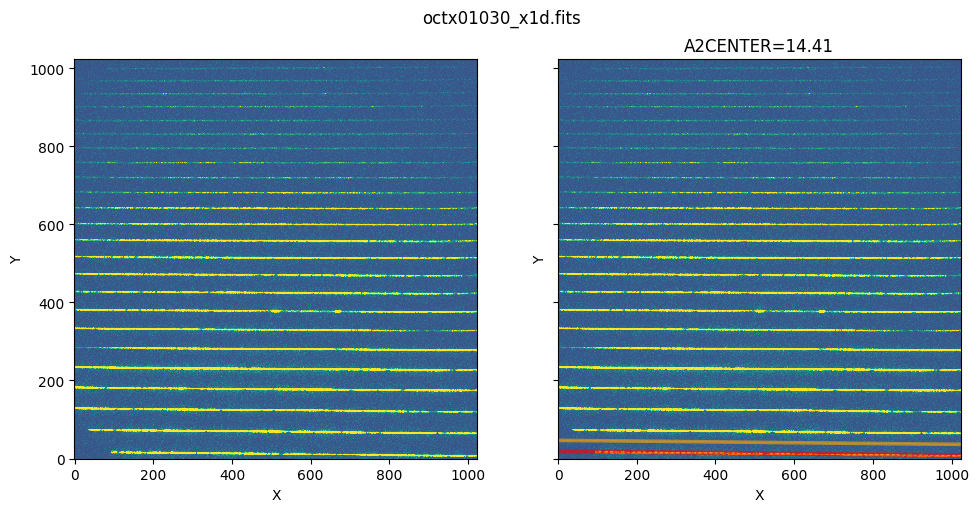

In [12]:
show_extraction_regions(echelle_x1d, echelle_flt)

Similarly, we can show the extraction region of the next `SPORDER` by passing the row number into the plotting method:

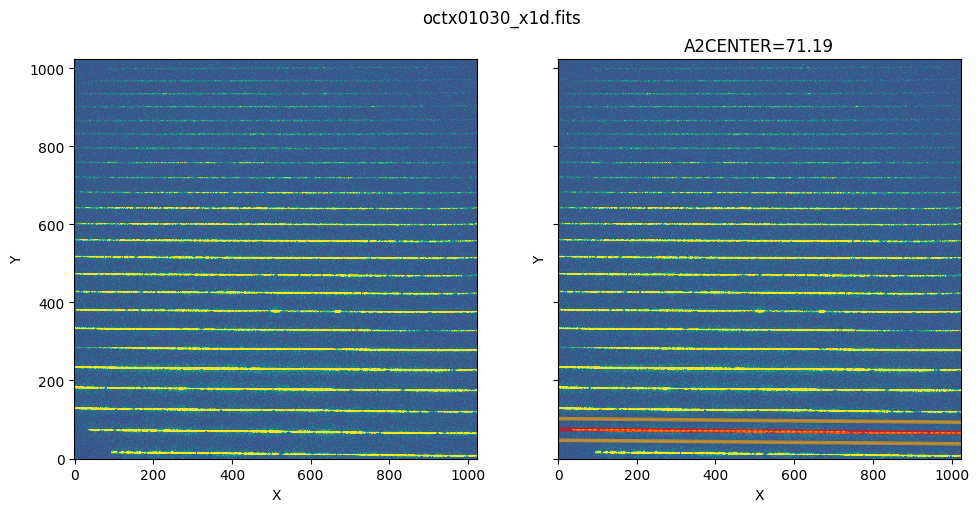

In [13]:
show_extraction_regions(echelle_x1d, echelle_flt, row=1)

After visualizing the extraction, we can use the `x1d()` function in stistools to customize extraction. For more information, see [`x1d`](https://stistools.readthedocs.io/en/latest/x1d.html).

<a id=about></a>

---
## About this Notebook <a class="tocSkip">
**Author:** Keyi Ding

**Updated On:** 2023-01-05


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations <a class="tocSkip">

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)

<hr>

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 